In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from functools import partial
# from funcy import compose
compose = lambda *F: reduce(lambda f, g: lambda x: f(g(x)), F)
import numpy as np
from parametric_pde_find import *
from robust_pde_diff import DLrSR, RobustPCA
from scipy.integrate import odeint
from scipy.signal import savgol_filter, periodogram
from scipy.stats import wilcoxon
from numpy.fft import fft, ifft, fftfreq

from best_subset import *
from solvel0 import solvel0
from UBIC import fit_blr, UBIC, decreasing_values_indices
from para_UBIC import *

from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, KFold

from findiff import FinDiff

from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

def coeff_error(est, ground): return 100*np.linalg.norm(est-ground, 1)/np.linalg.norm(ground, 1)

def ssr2llf(ssr, nobs, epsilon=1e-5):
    nobs2 = nobs / 2.0
    # llf = -nobs2 * np.log(2 * np.pi) - nobs2 * np.log(ssr / nobs) - nobs2
    llf = -nobs2*np.log(2*np.pi*ssr/nobs+epsilon)
    return llf

def rss2bic(rss, nparams, nobs, epsilon=1e-5):
    # llf = ssr2llf(rss, nobs, epsilon)
    # return -2*llf + np.log(nobs)*nparams
    return nobs*np.log(2*np.pi*rss/nobs+epsilon) + np.log(nobs)*nparams

def BIC_Loss(As,bs,x,epsilon=1e-5):
    # D: Number of candidates | m: either len(t) or len(x) (temporal or spatial group)
    D,m = x.shape
    # n: Number of horizon
    n,_ = As[0].shape
    N = n*m
    # Complexity
    k = np.count_nonzero(x)/m
    # BIC
    res = np.vstack([bs[j] - As[j]@x[:, j:j+1] for j in range(m)])
    assert len(res) == n*m
    rss = np.linalg.norm(res, ord='fro')**2 
    # llf = -(N/2)*np.log(2*np.pi*rss/N+epsilon)
    # -2*llf + np.log(N)*k # AIC: -2*llf + 2*k
    # return -2*llf + np.log(N)*k
    return N*np.log(2*np.pi*rss/N+epsilon) + np.log(N)*k

np.random.seed(1234)
fontsize = 20

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
Sklearn's version: 1.2.2
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.


In [2]:
def advection_rhs(u, t, params):
    k, L, x = params    
    kappa = -1.5 + 1.0*np.cos(2*x*np.pi/L)
    deriv = ifft(1j*k*fft(kappa*u)) + 0.1*ifft(-k**2*fft(u))
    return real(deriv)

def spatial_temporal_group(Theta, Ut, domain_shape, dependent="temporal"):
    n, m = domain_shape
    assert n*m == Theta.shape[0], Ut.shape[0]
    if dependent == "temporal":
        Theta_grouped = [(Theta[j*n:(j+1)*n,:]).real for j in range(m)]
        Ut_grouped = [(Ut[j*n:(j+1)*n]).real for j in range(m)]
    elif dependent == "spatial":
        Theta_grouped = [(Theta[n*np.arange(m)+j,:]).real for j in range(n)]
        Ut_grouped = [(Ut[n*np.arange(m)+j]).real for j in range(n)]
    else: return
    return np.array(Theta_grouped), np.array(Ut_grouped)

def normalize_groups(As, bs, normalize=2):
    m = len(As)
    n,D = As[0].shape
    
    # get norm of each column
    candidate_norms = np.zeros(D)
    for i in range(D):
        candidate_norms[i] = Norm(np.vstack([A[:,i] for A in As]), normalize)

    norm_bs = [m*Norm(b, normalize) for b in bs]

    normalized_As = As.copy()
    normalized_bs = bs.copy()
    # normalize
    for i in range(m):
        normalized_As[i] = normalized_As[i].dot(np.diag(candidate_norms**-1))
        normalized_bs[i] = normalized_bs[i]/norm_bs[i]
        
    return normalized_As, normalized_bs

def remove_f(uu, percent):
    if percent <= 0: return uu
    PSD = (uu*np.conj(uu))/np.prod(uu.shape)
    PSD = PSD.real
    mask = (PSD>np.percentile(PSD, percent)).astype(np.float32)
    return uu*mask

In [3]:
# Set size of grid
n = 256
m = 256
L = 5

# Set up grid
x = np.linspace(-L,L,n+1)[:-1];   dx = x[1]-x[0]
t = np.linspace(0,5,m);         dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
np.random.seed(0)
u0 = np.cos(2*x*np.pi/L)
u01 = np.exp(-x**2)

# Solve with time dependent u_x term
params = (k,L,x)
u = odeint(advection_rhs, u0, t, args=(params,)).T
u1 = odeint(advection_rhs, u01, t, args=(params,)).T

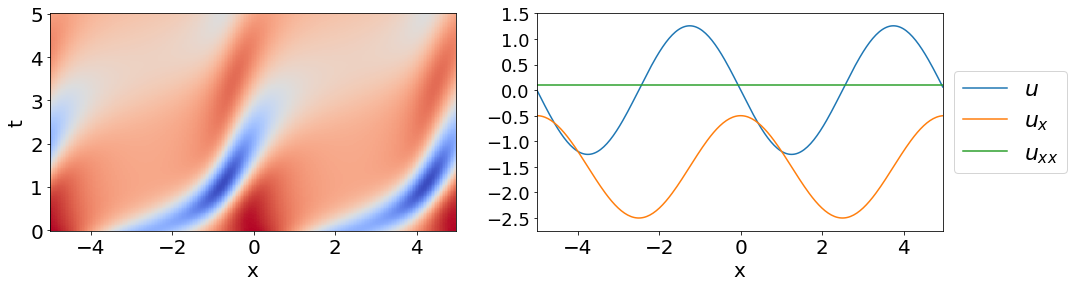

In [4]:
# Plot
u_x_true = -1.5 + 1.0*np.cos(2*x*np.pi/L) 
u_true = -2*np.pi/L*np.sin(2*x*np.pi/L)
u_xx_true = 0.1*np.ones(n)

fig = figure(figsize=(16,4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlim([x[0],x[-1]])

subplot(1,2,2)
plot(x,u_true, label='$u$')
plot(x,u_x_true, label='$u_{x}$')
plot(x,u_xx_true, label='$u_{xx}$')
xlim([x[0],x[-1]])
ylim([-2.75, 1.5])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize-2)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
show()
# fig.tight_layout()

In [5]:
noise_lv = 2
noise_lv = abs(noise_lv)
u_clean = u.copy()
u = u + 0.01*noise_lv*std(u)*np.random.randn(*u.shape)

In [6]:
is_denoising = True
if is_denoising and noise_lv > 0:
    window_size = 15
    poly_order = 2
    # equivalent to np.hstack([savgol_filter(u[:, i], window_size, poly_order).reshape(-1, 1) for i in range(u.shape[-1])])
    u = savgol_filter(u, window_size, poly_order, axis=0)

In [7]:
# Ut, Theta, rhs_des = build_linear_system(u, dt, dx, D=4, P=3, 
#                                          time_diff = 'FD', space_diff = 'Fourier')
alpha = 1e-3
diff_kwargs = {"kind": "kalman", "alpha": alpha}
Ut, Theta, Ut_grouped, Theta_grouped, rhs_des = construct_group_linear_system(u, x, t, 
                                                                        diff_kwargs, 
                                                                        include_bias=False)
# Theta_grouped, Ut_grouped = spatial_temporal_group(Theta, Ut, (n,m), "spatial")

fft_percent = 90
fft_Theta_grouped = np.array([remove_f(fft(Theta_grouped[:, :, k]), fft_percent) 
                              for k in range(len(rhs_des))])
fft_Theta_grouped = np.moveaxis(fft_Theta_grouped, 0, -1)
fft_Ut_grouped = remove_f(fft(Ut_grouped[:, :, 0]), fft_percent)
fft_Ut_grouped = np.expand_dims(fft_Ut_grouped, -1)

# physics is such fundamental that it can be discovered from in low-freq data (validation set)
# fft_percent = 90
# acc = 8
# d_dx = FinDiff(0, dx, 1, acc=acc); u_x = d_dx(u)
# d_dxx = FinDiff(0, dx, 2, acc=acc); u_xx = d_dxx(u)
# d_dxxx = FinDiff(0, dx, 3, acc=acc); u_xxx = d_dxxx(u)
# d_dt = FinDiff(1, dt, 1, acc=acc); u_t = d_dt(u)
    
# phi1 = [u**i for i in range(0, 4)]; phi1_names = ["", "u", "u^{2}", "u^{3}"]
# phi2 = [u_x, u_xx, u_xxx]; phi2_names = ["u_{x}", "u_{xx}", "u_{xxx}"]
# phi = phi1.copy(); phi_names = phi1_names.copy()
# phi.extend([p1*p2 for p1 in phi1 for p2 in phi2])
# phi = np.array(phi)
# phi_names.extend([p1+p2 for p1 in phi1_names for p2 in phi2_names])
# fft_phi = [remove_f(fft(_), fft_percent) for _ in phi]
# fft_u_t = remove_f(fft(u_t), fft_percent)

# Theta_grouped = np.moveaxis(phi, 0, -1)
# Ut_grouped = np.expand_dims(u_t, -1)
# rhs_des = phi_names
# fft_Theta_grouped = np.moveaxis(fft_phi, 0, -1)
# fft_Ut_grouped = np.expand_dims(fft_u_t, -1)

# del phi1, phi2, phi1_names, phi2_names

0 u
3 u_x
4 u_xx


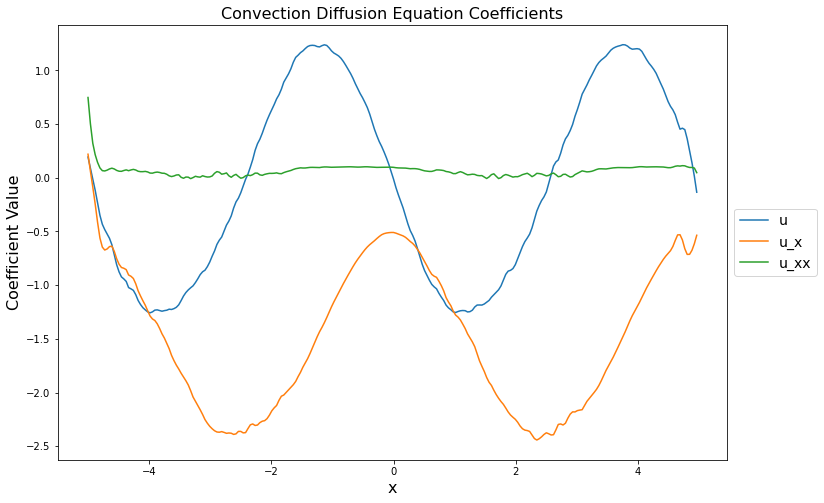

In [8]:
# Solve and plot
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, rhs_des[j])
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Convection Diffusion Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
show()

In [9]:
candidates = set()
# max_complexity=X_weak.shape[-1]
max_complexity = 10
for i in trange(len(Theta_grouped)):    
    candidates = candidates.union(set(solvel0(Theta_grouped[i], Ut_grouped[i], 
                                              max_complexity=max_complexity, 
                                              miosr=True, refine=True, verbose=False)))
candidates

  0%|                                                                                                                             | 0/256 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [01:37<00:00,  2.63it/s]


{(0, 1, 2, 3, 4, 5, 6),
 (0, 1, 2, 3, 4, 5, 6, 7),
 (0, 1, 2, 3, 4, 5, 6, 7, 8),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 11),
 (0, 1, 2, 3, 4, 5, 6, 7, 8, 16),
 (0, 1, 2, 3, 4, 5, 6, 7, 9),
 (0, 1, 2, 3, 4, 5, 6, 7, 9, 11),
 (0, 1, 2, 3, 4, 5, 6, 7, 10, 16),
 (0, 1, 2, 3, 4, 5, 6, 7, 11),
 (0, 1, 2, 3, 4, 5, 6, 7, 11, 12),
 (0, 1, 2, 3, 4, 5, 6, 7, 11, 13),
 (0, 1, 2, 3, 4, 5, 6, 7, 11, 15),
 (0, 1, 2, 3, 4, 5, 6, 7, 11, 16),
 (0, 1, 2, 3, 4, 5, 6, 7, 12),
 (0, 1, 2, 3, 4, 5, 6, 7, 12, 14),
 (0, 1, 2, 3, 4, 5, 6, 7, 12, 15),
 (0, 1, 2, 3, 4, 5, 6, 7, 13),
 (0, 1, 2, 3, 4, 5, 6, 7, 13, 15),
 (0, 1, 2, 3, 4, 5, 6, 7, 14),
 (0, 1, 2, 3, 4, 5, 6, 7, 15),
 (0, 1, 2, 3, 4, 5, 6, 7, 16),
 (0, 1, 2, 3, 4, 5, 6, 7, 16, 17),
 (0, 1, 2, 3, 4, 5, 6, 7, 17),
 (0, 1, 2, 3, 4, 5, 6, 8),
 (0, 1, 2, 3, 4, 5, 6, 8, 9),
 (0, 1, 2, 3, 4, 5, 6, 8, 11, 12),
 (0, 1, 2, 3, 4, 5, 6, 8, 11, 14),
 (0, 1, 2, 3, 4, 5, 6, 8, 11, 15),
 (0, 1, 2, 3, 4, 5, 6, 8, 12),
 (0, 1, 2, 3, 4, 5, 6, 8, 15),
 (0, 1, 2, 3, 4, 5, 6, 11),
 (0

In [10]:
lam = 0
for j in range(len(Ut_grouped)):
    est_xi = Ridge(alpha=0, fit_intercept=False).fit(Theta_grouped[j], Ut_grouped[j]).coef_.reshape(-1, 1)
    difference = Ut_grouped[j] - Theta_grouped[j].dot(est_xi)
    lam += (np.linalg.norm(difference, 2)**2)/(np.linalg.norm(est_xi, 2)**2)
lam /= len(Ut_grouped)
print("lam:", lam)

track = {}
for indices in tqdm(candidates):
    com = len(indices)
    rss = 0
    for j in range(len(Ut_grouped)):
        est_xi = Ridge(alpha=lam, fit_intercept=False).fit(Theta_grouped[j][:, indices], Ut_grouped[j]).coef_.reshape(-1, 1)
        difference = fft_Ut_grouped[j] - fft_Theta_grouped[j][:, indices].dot(est_xi)
        rss += np.linalg.norm(difference, 2)**2 + lam*np.linalg.norm(est_xi, 2)**2
    if com not in track or track[com][1] > rss:
        track[com] = indices, rss
candidates = set([e[0] for e in list(track.values())])
candidates

lam: 0.16270322461779022


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 812/812 [01:48<00:00,  7.47it/s]


{(0, 1, 2, 3, 4, 7, 8),
 (0, 1, 2, 3, 4, 7, 8, 11, 15, 16),
 (0, 1, 2, 3, 4, 7, 8, 15, 16),
 (0, 1, 2, 3, 4, 7, 8, 16),
 (0, 1, 3, 5, 6, 7, 11, 13, 15, 16, 18),
 (0, 3),
 (0, 3, 4),
 (0, 3, 4, 6, 7),
 (0, 3, 4, 6, 7, 10),
 (0, 3, 4, 7),
 (3,)}

3
10


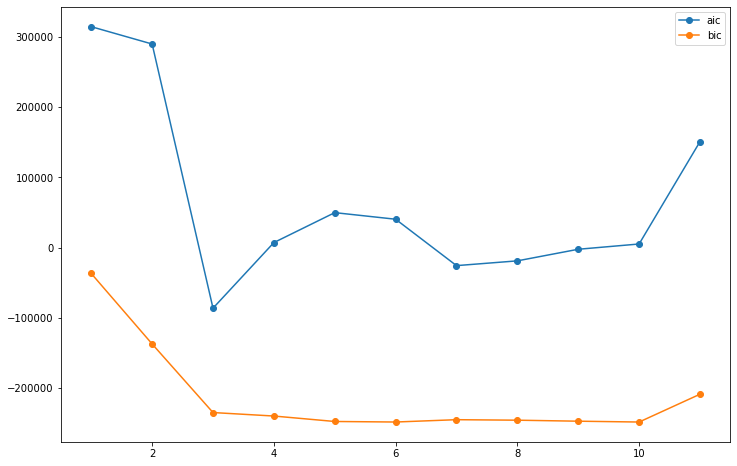

In [11]:
time_integrator = lambda _: _
time_integrator = partial(trapz, axis=0)
# psd = lambda _: np.expand_dims(power_spectral_density(_[:, :, 0]), -1)
psd = partial(power_spectral_density, axis=1)
time_integrator = compose(time_integrator, psd)
ic_scores = {}
for indices in candidates:
    est_xi = np.zeros((Theta_grouped[0].shape[-1], len(Ut_grouped)))
    for j in range(len(Theta_grouped)):
        est_xi[indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, indices], Ut_grouped[j], rcond=None)[0]
        
    # aic = PDE_FIND_Loss(Theta_grouped, Ut_grouped, est_xi)
    Ut_grouped_est = estimate_Ut_grouped_est(Theta_grouped, est_xi)
    rss = rss_group(Ut_grouped_est, Ut_grouped, time_integrator)
    N = np.prod(Ut_grouped.shape); k = len(np.where(np.linalg.norm(est_xi, axis=-1)>0)[0])
    aic = N*np.log(rss/N+1e-5) + 2*k+(2*k**2+2*k)/(N-k-1)
    
    bic = BIC_Loss(Theta_grouped, Ut_grouped, est_xi)
    
    if len(indices) not in ic_scores: ic_scores[len(indices)] = (aic, bic, indices)
    elif aic < ic_scores[len(indices)][0]: ic_scores[len(indices)] = (aic, bic, indices)

com_ics = sorted([(len(e[2]), e[0], e[1]) for e in list(ic_scores.values())])
complexities = [e[0] for e in com_ics]
aics = [e[1] for e in com_ics]
bics = [e[2] for e in com_ics]
print(complexities[np.argmin(aics)])
print(complexities[np.argmin(bics)])
plt.plot(complexities, aics, '-o', label='aic')
plt.plot(complexities, bics, '-o', label='bic')
plt.legend()
plt.show()

In [12]:
best_subsets = {}
for indices in candidates:
    est_xi = []
    uncert = 0.0
    rss = 0.0
    for j in trange(0, len(Theta_grouped), 1):        
        # model = Ridge(alpha=lam, fit_intercept=False)
        model = BayesianRidge(fit_intercept=False)
        model.fit(Theta_grouped[j][:, indices], Ut_grouped[j])
        post_prediction = (fft_Theta_grouped[j][:, indices]@model.coef_).reshape(-1, 1)
        rss = rss + np.linalg.norm(fft_Ut_grouped[j] - post_prediction)**2
        
        coeff = model.coef_.reshape(-1, 1)
        uncert = uncert + np.sqrt(np.diag(model.sigma_)).sum()/abs(model.coef_).sum()
        est_xi.append(coeff)
        
    if len(indices) not in best_subsets: best_subsets[len(indices)] = (rss, uncert, indices)
    elif rss < best_subsets[len(indices)][0]: best_subsets[len(indices)] = (rss, uncert, indices)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 256/256 [00:00<00:00, 1684.74it/s]


epsilon 145.54719305240926
5
(0, 3, 4, 6, 7)


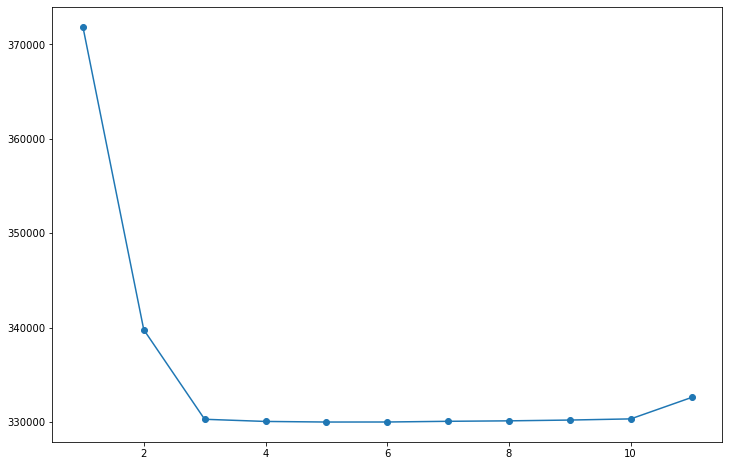

In [13]:
nobs = Theta_grouped[0].shape[0]*len(Ut_grouped)
min_uncert = np.min([best_subsets[com][1] for com in best_subsets])
epsilon = 1
epsilon = epsilon*max(1e-5, np.max([2*np.pi*best_subsets[com][0]/nobs for com in best_subsets]))
print("epsilon", epsilon)
complexities = sorted(best_subsets.keys())
bics = []
uncertainties = []
for com in complexities:
    rss, uncert, indices = best_subsets[com]
    uncert = uncert/min_uncert
    uncertainties.append(uncert)
    bics.append(rss2bic(rss, com+uncert, nobs, epsilon))
uncertainties = np.array(uncertainties)
best_indices = best_subsets[complexities[np.argmin(bics)]][-1]
print(complexities[np.argmin(bics)])
print(best_indices)
plt.plot(complexities, bics, '-o'); plt.show()

In [14]:
# verbose = True
# tau = 3
# b_bics = []
# lower_bounds = []
# for com in complexities:
#     rss, _, indices = best_subsets[com]
#     assert com == len(indices)
#     # lower_bound = 2*ssr2llf(rss, nobs)/np.log(nobs)-com
#     lower_bound = 2*np.abs(ssr2llf(rss, nobs))/np.log(nobs)-com
#     lower_bounds.append(lower_bound)
#     b_bics.append(rss2bic(rss, com, nobs, epsilon))
    
# last_lam = np.log10(max(max(lower_bounds/uncertainties), 1e-8))
# delta = last_lam/tau
# now_lam = last_lam-delta
# last_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**last_lam)
# last_bc = np.argmin(last_ubic)

# thres = 1e-4
# percent = 75
# b_bics = np.array(b_bics)
# complexities = np.array(complexities)
# d_complexities = complexities[decreasing_values_indices(b_bics)]
# d_bics = b_bics[decreasing_values_indices(b_bics)]
# thres = max(thres, np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), percent))

# while now_lam >= 0:
#     now_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**now_lam)
#     now_bc = np.argmin(now_ubic)

#     diff_com = now_bc-last_bc
#     diff_bic = b_bics[now_bc]-b_bics[last_bc]

#     imp = np.nan
#     if np.abs(diff_com) > 0:
#         imp = abs(diff_bic/(b_bics[last_bc]*diff_com))

#     if verbose:
#         print(last_bc, '--->', now_bc, np.nan_to_num(imp, nan=np.inf))

#     if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
#         (diff_com < 0 and diff_bic > 0 and imp > thres):
#         print("break")
#         break

#     last_lam = now_lam
#     now_lam = last_lam-delta
#     last_ubic = now_ubic
#     last_bc = now_bc
#     now_lam = round(now_lam, 8)
    
# last_lam = abs(round(last_lam, 8))
# best_indices = best_subsets[complexities[last_bc]][-1]; print(best_indices, "selected")
# print(last_lam, last_ubic, last_bc)
# # plt.plot(uncertainties)
# plt.plot(last_ubic)
# plt.show()

In [15]:
nfft = max(fft_Ut_grouped[:, :, 0].shape)
nfft = None
ground_periogram = periodogram(ifft(fft_Ut_grouped[:, :, 0]), nfft=nfft)[-1]
N = np.prod(ground_periogram.shape)
epsilons = []
for com in complexities:
    est_xi = np.zeros((fft_Theta_grouped[0].shape[-1], len(fft_Ut_grouped)))
    eff_indices = best_subsets[com][-1]
    for j in range(len(Theta_grouped)):
        est_xi[eff_indices, j:j+1] = BayesianRidge(fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
                                                                            Ut_grouped[j].flatten()).coef_.reshape(-1, 1)
#         est_xi[eff_indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, eff_indices], 
#                                                      Ut_grouped[j], 
#                                                      rcond=None)[0]
    pred_group = ifft(prediction_group(fft_Theta_grouped, est_xi))
    pred_periogram = periodogram(pred_group, nfft=nfft)[-1]

    res = np.vstack([ground_periogram[j]-pred_periogram[j] for j in range(len(Theta_grouped))])
    rss = np.linalg.norm(res, ord='fro')**2
    epsilons.append(2*np.pi*rss/N)
epsilon = max(epsilons)
epsilon

8.145066275929574

3


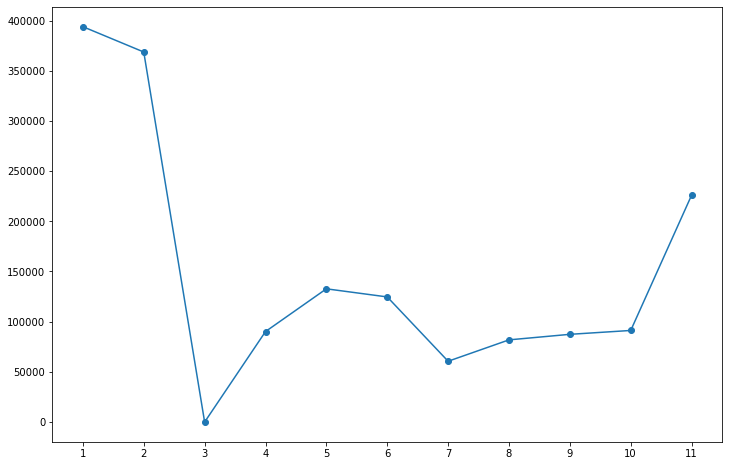

In [16]:
epsilon = 1e-5
time_integrator = lambda _: _
time_integrator = partial(trapz, axis=0)
ics = []
rss_list = []
varying_bics = []
for com in complexities:
    vbics = []
    est_xi = np.zeros((fft_Theta_grouped[0].shape[-1], len(fft_Ut_grouped)))
    eff_indices = best_subsets[com][-1]
    for j in range(len(Theta_grouped)):
        est_xi[eff_indices, j:j+1] = BayesianRidge(fit_intercept=False).fit(Theta_grouped[j][:, eff_indices], 
                                                                            Ut_grouped[j].flatten()).coef_.reshape(-1, 1)
#         est_xi[eff_indices, j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, eff_indices], 
#                                                      Ut_grouped[j], 
#                                                      rcond=None)[0]
        post_prediction = fft_Theta_grouped[j][:, eff_indices]@(est_xi[eff_indices, j:j+1])
        post_prediction = periodogram(ifft(post_prediction.flatten()))[-1]
        ground = periodogram(ifft(fft_Ut_grouped[j].flatten()))[-1]
        rss = np.linalg.norm(ground - post_prediction, 2)**2
        vbics.append(rss2bic(rss, com, len(post_prediction), 1e-5))       
        
    pred_group = ifft(prediction_group(fft_Theta_grouped, est_xi))
    pred_periogram = periodogram(pred_group, nfft=nfft)[-1]
    diff_periogram = time_integrator(ground_periogram)-time_integrator(pred_periogram)
    res = np.vstack([diff_periogram[j] for j in range(len(Theta_grouped))])
    rss = np.linalg.norm(res, ord='fro')**2
    ics.append(N*np.log(2*np.pi*rss/N+epsilon) + np.log(N)*(com+uncertainties[com-1]))
    rss_list.append(rss)
    varying_bics.append(vbics)

varying_bics = np.array(varying_bics)
varying_bics_ranking = np.argsort(varying_bics.sum(axis=-1))
print(np.argmin(ics)+1)
plt.plot(complexities, ics-min(ics), '-o')
plt.xticks(complexities)
plt.show()

In [17]:
verbose = True
tau = 3
b_bics = []
lower_bounds = []
for com in complexities:
    _, _, indices = best_subsets[com]
    rss = rss_list[com-1]
    assert com == len(indices)
    lower_bound = 2*np.abs(ssr2llf(rss, nobs))/np.log(nobs)-com
    lower_bounds.append(lower_bound)
    b_bics.append(rss2bic(rss, com, nobs, epsilon))
    
last_lam = np.log10(max(max(lower_bounds/uncertainties), 1e-8))
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**last_lam)
last_bc = np.argmin(last_ubic)

thres = 1e-4
percent = 60 # 75 # 90 (เพราะไม่เอา complexity = 1)
b_bics = np.array(b_bics)
complexities = np.array(complexities)
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
thres = max(thres, np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), percent))
pcut = 0.01
print("Threshold:", thres)
print("P-value threshold:", pcut)

while now_lam >= 0:
    now_ubic = UBIC(b_bics, uncertainties, nobs, hyp=10**now_lam)
    now_bc = np.argmin(now_ubic)

    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    diff_vbic = (varying_bics[now_bc]-varying_bics[last_bc])
    
    diff_vbic_adj = np.array([-np.inf for _ in range(1000)])
    adj_bc = varying_bics_ranking[varying_bics_ranking<now_bc]
    if len(adj_bc) > 0:
        adj_bc = adj_bc[0]
        diff_vbic_adj = varying_bics[now_bc]-varying_bics[adj_bc]

    imp = np.nan
    pvalue_pos = pvalue_neg = pvalue_adj = np.nan
    if np.abs(diff_com) > 0:
        # imp < thres <--> pvalue > pcut
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
        pvalue_pos = wilcoxon(diff_vbic, alternative='less').pvalue
        pvalue_neg = wilcoxon(-diff_vbic, alternative='less').pvalue
        pvalue_adj = wilcoxon(diff_vbic_adj, alternative='less').pvalue

    # new version using wilcoxon test
    if verbose:
        print(last_bc, '--->', adj_bc, '--->', now_bc, 'p-value:', 
              np.nan_to_num(pvalue_pos, nan=np.inf), 
              np.nan_to_num(pvalue_neg, nan=np.inf), 
              np.nan_to_num(pvalue_adj, nan=np.inf))
    if (diff_com > 0 and (diff_bic > 0 or pvalue_pos > pcut or pvalue_adj > pcut)) or \
        (diff_com < 0 and diff_bic > 0 and pvalue_pos > pcut and pvalue_neg <= pcut):
        break

    ### old version using threshold ###
    #     if verbose:
    #         print(last_bc, '--->', now_bc, 'imp:', np.nan_to_num(imp, nan=np.inf))
    #     if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
    #         (diff_com < 0 and diff_bic > 0 and imp > thres):
    #         break

    last_lam = now_lam
    now_lam = last_lam-delta
    last_ubic = now_ubic
    last_bc = now_bc
    now_lam = round(now_lam, 8)
    
last_lam = abs(round(last_lam, 8))
best_indices = best_subsets[complexities[last_bc]][-1]; print(best_indices, "selected")
last_lam, last_ubic, last_bc

Threshold: 0.6322265025437042
P-value threshold: 0.01
2 ---> 1 ---> 2 p-value: inf inf inf
2 ---> 1 ---> 2 p-value: inf inf inf
2 ---> 1 ---> 2 p-value: inf inf inf
(0, 3, 4) selected


(0.0,
 array([390038.70904342, 364805.84319603,  -3853.22593788,  86286.89795633,
        128867.27725914, 120788.17849594,  56710.19060272,  78009.51441716,
         83532.43476136,  87385.52773685, 222206.25497369]),
 2)

3


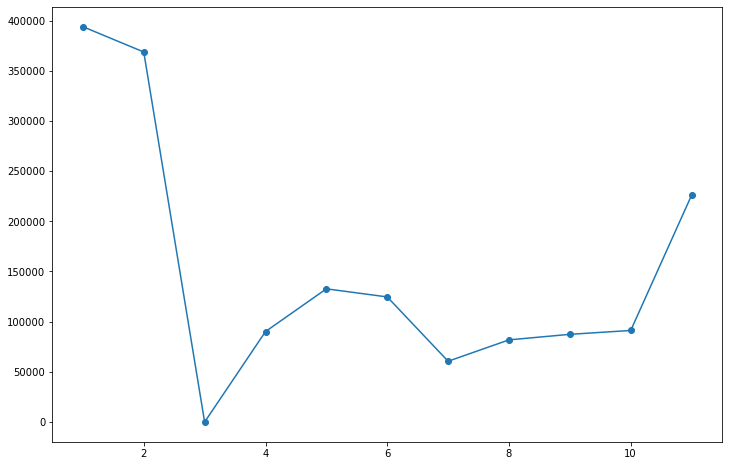

In [18]:
print(np.argmin(last_ubic)+1)
plt.plot(complexities, last_ubic-min(last_ubic), '-o'); plt.show()

In [19]:
varying_bics = []
pvalues = [0.0]
for indices in sorted(candidates, key=len):
    vbics = []
    for j in range(0, len(Theta_grouped), 1):
        model = BayesianRidge(fit_intercept=False)
        model.fit(Theta_grouped[j][:, indices], Ut_grouped[j])
        post_prediction = (fft_Theta_grouped[j][:, indices]@model.coef_).reshape(-1, 1)
        # periodogram calculation like weak formulation
        post_prediction = periodogram(ifft(post_prediction.flatten()))[-1]
        ground = periodogram(ifft(fft_Ut_grouped[j].flatten()))[-1]
        rss = np.linalg.norm(ground - post_prediction, 2)**2
        vbics.append(rss2bic(rss, com, len(post_prediction), 1e-5))
    pvalue = np.nan
    if len(varying_bics) > 0:
        wres = wilcoxon(vbics, varying_bics[-1], alternative='less')
        pvalue = wres.pvalue
        pvalues.append(pvalue)
    varying_bics.append(vbics)
    print(indices, pvalue)
    
varying_bics = np.array(varying_bics)
# summ_bics = varying_bics.sum(axis=-1)
# assert len(summ_bics) == len(pvalues)

(3,) nan
(0, 3) 1.6450599944943604e-31
(0, 3, 4) 1.0084173763017436e-38
(0, 3, 4, 7) 0.9999999999105276
(0, 3, 4, 6, 7) 2.1275443696924656e-05
(0, 3, 4, 6, 7, 10) 3.580063105710496e-05
(0, 1, 2, 3, 4, 7, 8) 0.8740998216178375
(0, 1, 2, 3, 4, 7, 8, 16) 0.9996012146496804
(0, 1, 2, 3, 4, 7, 8, 15, 16) 0.3046705363158094
(0, 1, 2, 3, 4, 7, 8, 11, 15, 16) 0.0054910844213481675
(0, 1, 3, 5, 6, 7, 11, 13, 15, 16, 18) 0.999999912042447


In [20]:
pcut = 0.01
min_bic = np.inf
j = None
sig_complexities = []
for i, pvalue in enumerate(pvalues):
    if i == 0: pvalue = 0.0
    else: pvalue = wilcoxon(varying_bics[i]-varying_bics[j], alternative='less').pvalue
    if ics[i] < min_bic and pvalue < pcut:
        min_bic = ics[i]
        j = i
        if pvalue < pcut:
            sig_complexities.append(i+1)
            print(i+1)

1
2
3


In [21]:
# propose
# significant testing (จำนวนกลุ่มตัวอย่างที่สุ่มออกมาเท่ากับ len(x) or len(t)) 
# + BIC in peridogram (& weak-form space for ordinary PDEs)
# note: epsilon = 1e-5
# metric learning not sure ... (optional)
# target PDEs Parametric Burgers, AD, KS + (Burgers&KS for ordinary PDEs)